In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import os
import tensorflow as tf
import zipfile
from tensorflow import keras
from tensorflow.keras import layers
import nibabel as nib
import glob
from sklearn.utils import shuffle
import sys


In [ ]:
from keras.utils import np_utils
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta, SGD
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from keras.models import Model
import cv2
import os
import numpy as np
import keras
import h5py
import numpy as np
from keras import regularizers
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model
import keras

In [ ]:
from keras.engine import Input, Model
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D,\
                         GlobalMaxPooling3D, AveragePooling3D, Dense, Flatten,\
                         Conv1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Reshape, Activation
from keras.layers.merge import Concatenate, add
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping


In [ ]:
x_train = np.load("/content/drive/MyDrive/thesis2/x_train_minmax_normalized.npy")
y_train = np.load("/content/drive/MyDrive/thesis2/y_training.npy")

In [ ]:
x_train.shape,y_train.shape

((6000, 64, 64, 33), (6000,))

In [ ]:
# x_mean = np.mean(x_train)
# x_std = np.std(x_train)
# x_mean,x_std
# # (1553.0166624964165, 3575.5203140146095)

(0.22945192119659386, 0.10349581814834698)

In [ ]:
np.max(x_train),np.min(x_train)

(1.0, 0.0)

In [ ]:
m , mi = 28822.50390625, -6477.419921875

In [ ]:
# x_train = (x_train- x_mean)/x_std

In [ ]:
x_test = np.load("/content/drive/MyDrive/thesis2/x_test.npy")
y_test = np.load("/content/drive/MyDrive/thesis2/y_test.npy")

In [ ]:
x_test.shape,y_test.shape

((1500, 64, 64, 33), (1500,))

In [ ]:
x_test = (x_test - mi) / (m - mi)

In [ ]:
x_val = np.load("/content/drive/MyDrive/thesis2/x_validation.npy")
y_val = np.load("/content/drive/MyDrive/thesis2/y_validation.npy")

In [ ]:
x_val.shape,y_val.shape

((1500, 64, 64, 33), (1500,))

In [ ]:
x_val = (x_val - mi) / (m - mi)

In [ ]:
def phinet(n_classes, n_channels=1, learning_rate=1e-3):

    inputs = keras.Input((64, 64, 33, 1))

    x = Conv3D(8, (3,3,3), strides=(2,2,2), padding='same')(inputs)
    x = MaxPooling3D(pool_size=(3,3,3), strides=(1,1,1), padding='same')(x)

    x = Conv3D(16, (3,3,3), strides=(2,2,2), padding='same')(x)
    x = BatchNormalization()(x)
    y = Activation('relu')(x)
    x = Conv3D(16, (3,3,3), strides=(1,1,1), padding='same')(y)
    x = BatchNormalization()(x)
    x = add([x, y])
    x = Activation('relu')(x)

    # this block will pool a handful of times to get the "big picture" 
    y = MaxPooling3D(pool_size=(5,5,5), strides=(2,2,2), padding='same')(inputs)
    y = AveragePooling3D(pool_size=(3,3,3), strides=(2,2,2), padding='same')(y)
    y = Conv3D(16, (3,3,3), strides=(1,1,1), padding='same')(y)

    # this layer will preserve original signal
    z = Conv3D(8, (3,3,3), strides=(2,2,2), padding='same')(inputs)
    z = Conv3D(12, (3,3,3), strides=(2,2,2), padding='same')(z)
    z = Conv3D(16, (3,3,3), strides=(1,1,1), padding='same')(z)

    x = Concatenate(axis=4)([x, y, z])

    # global avg pooling before FC
    x = GlobalAveragePooling3D()(x)
    x = Dense(1)(x)

    pred = Activation('sigmoid')(x)


    initial_learning_rate = 0.0001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

    model = Model(inputs=inputs, outputs=pred)

    model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

    print(model.summary())

    return model

In [ ]:
callbacks_list = []
checkpoint = ModelCheckpoint("3d_image_classification.h5",
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max',
                                 save_weights_only=False)
callbacks_list.append(checkpoint)

# Dynamic Learning Rate
dlr = ReduceLROnPlateau(monitor="val_acc", factor=0.5, patience=5,
                            mode='max', verbose=1, cooldown=5, min_lr=1e-8)
callbacks_list.append(dlr)

In [ ]:
model = phinet(n_classes=2, learning_rate=1e-3)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 33,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 32, 17, 8 224         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 32, 32, 17, 8 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 16, 16, 9, 16 3472        max_pooling3d[0][0]              
______________________________________________________________________________________________

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
history = model.fit(
    x = x_train,y = y_train,
    validation_data=(x_val,y_val),
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
188/188 - 23s - loss: 0.6631 - acc: 0.5277 - val_loss: 0.6289 - val_acc: 0.7000
Epoch 2/100
188/188 - 6s - loss: 0.6448 - acc: 0.5447 - val_loss: 0.6428 - val_acc: 0.7000
Epoch 3/100
188/188 - 6s - loss: 0.6294 - acc: 0.5957 - val_loss: 0.5924 - val_acc: 0.7000
Epoch 4/100
188/188 - 6s - loss: 0.6011 - acc: 0.6997 - val_loss: 0.5719 - val_acc: 0.7000
Epoch 5/100
188/188 - 6s - loss: 0.5647 - acc: 0.7823 - val_loss: 0.5464 - val_acc: 0.7000
Epoch 6/100
188/188 - 6s - loss: 0.5351 - acc: 0.8122 - val_loss: 0.5320 - val_acc: 0.7000
Epoch 7/100
188/188 - 6s - loss: 0.5092 - acc: 0.8475 - val_loss: 0.7696 - val_acc: 0.3873
Epoch 8/100
188/188 - 6s - loss: 0.4819 - acc: 0.8698 - val_loss: 0.5498 - val_acc: 0.8953
Epoch 9/100
188/188 - 6s - loss: 0.4587 - acc: 0.8932 - val_loss: 0.5049 - val_acc: 0.7000
Epoch 10/100
188/188 - 6s - loss: 0.4347 - acc: 0.9120 - val_loss: 0.5197 - val_acc: 0.7000
Epoch 11/100
188/188 - 6s - loss: 0.4118 - acc: 0.9343 - val_loss: 0.6117 - val_acc: 0.7

NameError: ignored

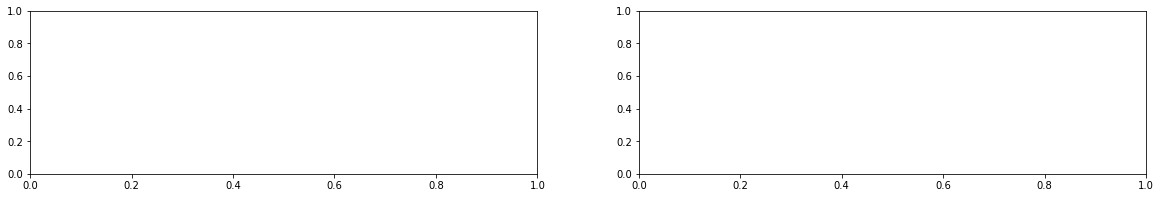

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
y_train[:10]

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 0])

In [ ]:
x_test2, y_test2= shuffle(x_test,y_test,random_state = 4)

In [ ]:
model.evaluate(x = x_test2,y = y_test2)

47/47 [==============================] - 1s 14ms/step - loss: 0.6222 - acc: 0.6933


[0.6221790909767151, 0.6933333277702332]

In [ ]:
model = load_model('3d_image_classification.h5')

In [ ]:
y_test2[:10]

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1])

In [ ]:
y_val[:10]

array([1, 0, 1, 0, 1, 1, 1, 0, 0, 1])

In [ ]:
y_train[:10]

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 0])

In [ ]:
cd /

/


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Orm2tbk5gljhnRrZ56onxRdmIUWvYt-X' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Orm2tbk5gljhnRrZ56onxRdmIUWvYt-X" -O finaltest.zip && rm -rf /tmp/cookies.txt


--2021-05-18 01:11:22--  https://docs.google.com/uc?export=download&confirm=Pgru&id=1Orm2tbk5gljhnRrZ56onxRdmIUWvYt-X
Resolving docs.google.com (docs.google.com)... 172.217.204.113, 172.217.204.100, 172.217.204.102, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-4g-docs.googleusercontent.com/docs/securesc/a2kqhgl0mhfegbonod65a92o7f8hmd7j/t2dmlfsb5570iai77fb5djdj32onk67v/1621300275000/10681116013986523016/11120665277389702228Z/1Orm2tbk5gljhnRrZ56onxRdmIUWvYt-X?e=download [following]
--2021-05-18 01:11:22--  https://doc-0o-4g-docs.googleusercontent.com/docs/securesc/a2kqhgl0mhfegbonod65a92o7f8hmd7j/t2dmlfsb5570iai77fb5djdj32onk67v/1621300275000/10681116013986523016/11120665277389702228Z/1Orm2tbk5gljhnRrZ56onxRdmIUWvYt-X?e=download
Resolving doc-0o-4g-docs.googleusercontent.com (doc-0o-4g-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Conne

In [ ]:
# from google.colab import files
# files.download('example.txt') 
!unzip /finaltest.zip -d /
print('done')

Archive:  /finaltest.zip
   creating: /scz_test/
  inflating: /scz_test/18.nii.gz     
  inflating: /scz_test/19.nii.gz     
  inflating: /scz_test/20.nii.gz     
  inflating: /scz_test/21.nii.gz     
  inflating: /scz_test/22.nii.gz     
  inflating: /scz_test/23.nii.gz     
  inflating: /scz_test/24.nii.gz     
  inflating: /scz_test/25.nii.gz     
  inflating: /scz_test/26.nii.gz     
  inflating: /scz_test/27.nii.gz     
  inflating: /scz_test/28.nii.gz     
  inflating: /scz_test/29.nii.gz     
  inflating: /scz_test/30.nii.gz     
  inflating: /scz_test/31.nii.gz     
   creating: /normal_test/
  inflating: /normal_test/18.nii.gz  
  inflating: /normal_test/19.nii.gz  
  inflating: /normal_test/20.nii.gz  
  inflating: /normal_test/21.nii.gz  
  inflating: /normal_test/22.nii.gz  
  inflating: /normal_test/23.nii.gz  
  inflating: /normal_test/24.nii.gz  
  inflating: /normal_test/25.nii.gz  
  inflating: /normal_test/26.nii.gz  
done


In [ ]:
normaltest = []
scztest = []

In [ ]:
flag = 0
count = 0
for file in glob.glob('/normal_test/*'):
  count= count+1
  print(file)
  img4d = nib.load(file)
  img3d_list = nib.funcs.four_to_three(img4d)
  for i in img3d_list:
    data = i.get_fdata()
    normaltest.append(data)
    
  #   if (len(scz)==2500):
  #     flag = 1
  #     if(flag == 1):
  #       break
  # if(flag == 1):
  #   break
print("done")
print(count)

/normal_test/19.nii.gz
/normal_test/21.nii.gz
/normal_test/25.nii.gz
/normal_test/23.nii.gz
/normal_test/20.nii.gz
/normal_test/22.nii.gz
/normal_test/24.nii.gz
/normal_test/18.nii.gz
/normal_test/26.nii.gz
done
9


In [ ]:
flag = 0
count = 0
for file in glob.glob('/scz_test/*'):
  count= count+1
  print(file)
  img4d = nib.load(file)
  img3d_list = nib.funcs.four_to_three(img4d)
  for i in img3d_list:
    data = i.get_fdata()
    scztest.append(data)
    
  #   if (len(scz)==2500):
  #     flag = 1
  #     if(flag == 1):
  #       break
  # if(flag == 1):
  #   break
print("done")
print(count)

/scz_test/29.nii.gz
/scz_test/19.nii.gz
/scz_test/21.nii.gz
/scz_test/25.nii.gz
/scz_test/28.nii.gz
/scz_test/23.nii.gz
/scz_test/30.nii.gz
/scz_test/31.nii.gz
/scz_test/20.nii.gz
/scz_test/22.nii.gz
/scz_test/24.nii.gz
/scz_test/18.nii.gz
/scz_test/27.nii.gz
/scz_test/26.nii.gz
done
14


In [ ]:
normaltest_labels = np.array([0 for _ in range(len(normaltest))])
scztest_labels = np.array([1 for _ in range(len(scztest))])


y = np.concatenate((normaltest_labels[:], scztest_labels[:]), axis=0)

In [ ]:
normaltest_array = np.asarray(normaltest)
normaltest_array = (normaltest_array - mi) / (m - mi)
scztest_array = np.asarray(scztest)
scztest_array = (scztest_array - mi) / (m - mi)


x_test = np.concatenate((normaltest_array[:], scztest_array[:]), axis=0)

In [ ]:
y.shape

(3450,)

In [ ]:
score = model.evaluate(x = x_test,y = y)

108/108 [==============================] - 2s 15ms/step - loss: 0.7168 - acc: 0.8014


In [ ]:
model.save('model1.h5')

In [ ]:
model = load_model('model1.h5')

In [ ]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 100.00%


In [ ]:
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()
    plt.show()

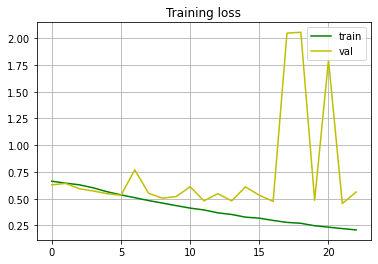

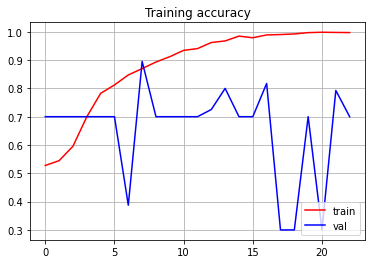

In [ ]:
plot_loss_accu(history) 